In [3]:
import Backbone
import requests
from io import BytesIO
from PIL import Image
from position_encoder import PositionEncoder
from Encoder import Encoder
import OA_Candidate_Sampler 
import torch.nn as nn
from importlib import reload
reload(Backbone)

reload(OA_Candidate_Sampler)

OACandidateSampler = OA_Candidate_Sampler.OACandidateSampler

In [4]:
import json

with open('unique_OA_Pairs.json','r') as f:
    UniqeOAPairs = json.load(f)


UniqeOAPairs = [tuple(pair) for pair in UniqeOAPairs]

In [5]:
num_oas = len(UniqeOAPairs) 

backbone = Backbone.Backbone()
positionEncoder = PositionEncoder()
encoder = Encoder()
OASampler = OACandidateSampler(num_oas)


In [6]:
with open('OA_Pairs.json','r') as f:
    id2OAPairs = json.load(f)

id2OAPairs = {id: list(set(tuple(pair) for pair in id2OAPairs[id])) for id in id2OAPairs.keys()}

In [7]:
import torch
id2OAOneHot = {}

for id, pairs in id2OAPairs.items():
    # Filter pairs that are in UniqeOAPairs
    valid_pairs = [pair for pair in pairs if pair in UniqeOAPairs]

    # Get indices of valid pairs
    indices = [UniqeOAPairs.index(pair) for pair in valid_pairs]

    # Convert indices to one-hot encoding
    oneHot = nn.functional.one_hot(torch.tensor(indices, dtype=int), num_classes=len(UniqeOAPairs))#gives batch of hot encoding (len(indices), len(UNiqeOAPairs))
    
    oneHot = oneHot.sum(axis = 0) #converts to single vector (1, len(UNiqeOAPairs))
    # Store the one-hot encodings for the ID
    id2OAOneHot[id] = oneHot

In [8]:
with open('vcoco_processed_data_all_2014.json', 'r') as f:
    vcoco_data = json.load(f)
    
ids = list(vcoco_data.keys())

train_ids = ids[:8000]
test_ids = ids[8000:10000]

train_data = [vcoco_data[id] for id in train_ids]
test_data = [vcoco_data[id] for id in test_ids]



In [9]:
imgs = [img] #we need to pass list of images to backbone

feature_map = backbone(imgs) #output from backbone
print('backbone output shape:', feature_map.shape)

position_encoded_feature_map = positionEncoder(feature_map)

B,C,W,H = position_encoded_feature_map.shape # (Batch, Channels, Width, Height)

backbone_output_vectorized = position_encoded_feature_map.reshape((B,C,W*H)) #changing 2d image to vector (B, C, F) (F = feature)
print('feature map vectorized shape:', backbone_output_vectorized.shape)

backbone_output_tansformed = backbone_output_vectorized.permute([0,2,1]) # (B, F, C)
print('feature map vectorized reshaped:', backbone_output_tansformed.shape)



encoder_output = encoder(backbone_output_tansformed) # (B, F, C)

print(encoder_output)
print(encoder_output.shape)


NameError: name 'img' is not defined

In [10]:
from collections import Counter

OApairsAll = []

for id, pairs in id2OAPairs.items():
    OApairsAll.extend([tuple(pair) for pair in pairs])    
    
    
indices = [UniqeOAPairs.index(pair) for pair in OApairsAll]
indices.sort()

pair_counts = Counter(indices)

weights = [pair_counts[index] for index in range(num_oas)]
max_weight = max(weights)
inverted_weights = [max_weight / weight for weight in weights]


In [11]:
import numpy as np
def get_image(file,url = False):
    if(url):
      response = requests.get(img_url)
      img = Image.open(BytesIO(response.content))
      img = img.convert("RGB") #remove alpha channel
    else:
        folder = '../images/'
        with open(folder+file, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
    return img
def get_batch(size=1):
    images = []
    y = []
    idx = np.random.randint(0,len(train_data)-size)
    for i,image in enumerate(train_data[idx:idx+size]):
        img_url = image['url']
        # img = get_image(img_url, url=True)
        img = get_image(image['file_name'])
        images.append(img)
        try:
            output = id2OAOneHot[str(image['id'])]
        # print(image['id'],output)
        except:
            output = torch.zeros(len(UniqeOAPairs)) #if OA pair doesn't exist
        y.append(output)
        
    return images,np.array(y)

get_batch(1)

([<PIL.Image.Image image mode=RGB size=640x427>],
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
len(train_data)

8000

In [13]:
vcoco_data['537316']

id2OAPairs['537316']

[('pizza', 'eat')]

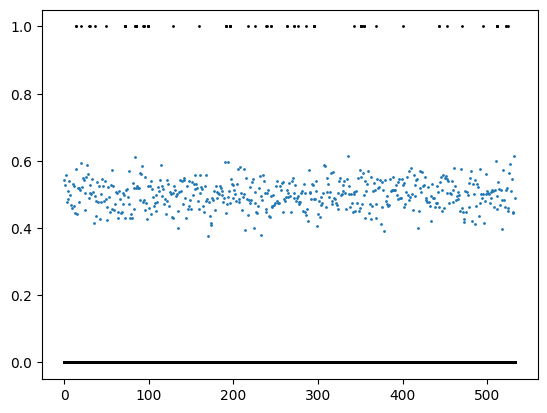

In [209]:
import matplotlib.pyplot as plt
plt.figure()
i = 1
plt.plot(probabilities[i].detach(), marker = 'o', ls = '', ms = 1)
plt.plot(y.T, marker = 'o', ls = '', ms = 1, c = 'black')

In [14]:
import torch
ims, y = get_batch(20)

feature_map = backbone(ims) #output from backbone
position_encoded_feature_map = positionEncoder(feature_map)
B,C,W,H = position_encoded_feature_map.shape # (Batch, Channels, Width, Height)
backbone_output_vectorized = position_encoded_feature_map.reshape((B,C,W*H)) #changing 2d image to vector (B, C, F) (F = feature)
backbone_output_tansformed = backbone_output_vectorized.permute([0,2,1]) # (B, F, C)
# backbone_output_tansformed = position_encoded_feature_map.permute([0,3,2,1]) # (B, H,W, C)
encoder_output = encoder(backbone_output_tansformed) # (B, F, C)

OASampler = OACandidateSampler(num_oas)
probabilities = OASampler(encoder_output)

print(probabilities.shape)
# confidences, indices = torch.topk(probabilities, 5, dim=-1)
# print("Top-K OA Candidates (indices):", indices)
# print("Top-K OA Candidates (confidences):", confidences)

torch.Size([20, 534])


In [9]:
import torch.nn as nn
class VectorizeFeatureMap(nn.Module):
    
    def __init__(self):
        super(VectorizeFeatureMap, self).__init__()
        
        for p in self.parameters():
            p._require_grad_(False)
    def forward(self, feature_map):
        B,C,W,H = feature_map.shape # (Batch, Channels, Width, Height)
        feature_map = feature_map.reshape((B,C,W*H)) #changing 2d image to vector (B, C, F) (F = feature)
        feature_map = feature_map.permute([0,2,1]) # (B, F, C)
        
        return feature_map

[<PIL.Image.Image image mode=RGB size=640x427 at 0x1539A2909B0>, <PIL.Image.Image image mode=RGB size=640x427 at 0x15399FA56A0>]
[['person' 'stand']
 ['person' 'smile']
 ['person' 'sit']
 ['chair' 'hold']
 ['dining table' 'hold']]


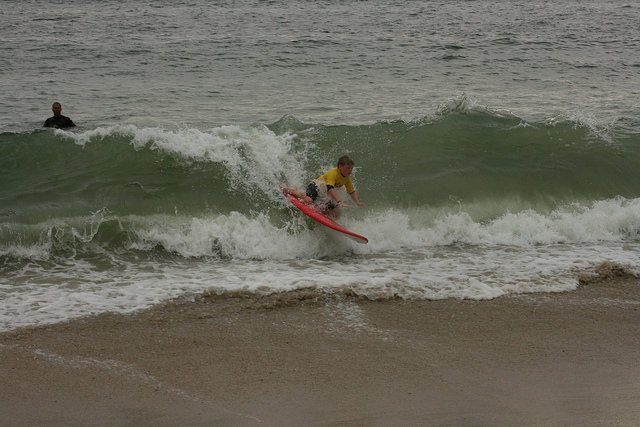

In [29]:
ims,y = get_batch(2)
print(ims)
predictions = model(ims)

predictions = nn.Softmax()(predictions)
probs, indices = torch.topk(predictions,5)

i = 1
print(np.array(UniqeOAPairs)[indices[i].numpy()])

ims[i]


In [60]:

probs = torch.sigmoid(probabilities)
probs.detach().numpy()[0]

array([0.4619529 , 0.4291467 , 0.40783277, 0.5070486 , 0.5078158 ,
       0.47378126, 0.48382154, 0.445149  , 0.51080227, 0.46408185,
       0.3742901 , 0.55709475, 0.4155079 , 0.50299525, 0.46901095,
       0.5088211 , 0.5687384 , 0.4624074 , 0.44888902, 0.4625982 ,
       0.51500094, 0.50150234, 0.4296336 , 0.44735244, 0.5083927 ,
       0.45183071, 0.46141988, 0.49883673, 0.47521117, 0.45028684,
       0.5054087 , 0.46368122, 0.44505572, 0.41043803, 0.48761225,
       0.51833075, 0.48346004, 0.5421095 , 0.48904628, 0.5098911 ,
       0.51679695, 0.4069848 , 0.3866648 , 0.47783267, 0.479171  ,
       0.42897   , 0.4833506 , 0.46307197, 0.40111762, 0.38151965,
       0.5698045 , 0.48380083, 0.51484096, 0.40736747, 0.4859976 ,
       0.54040164, 0.5051056 , 0.47254896, 0.4956311 , 0.43147546,
       0.48465782, 0.43425265, 0.37942758, 0.52261543, 0.47909936,
       0.49231273, 0.4528285 , 0.44190246, 0.41984877, 0.42135882,
       0.3976852 , 0.4505168 , 0.4434015 , 0.5241481 , 0.46625

In [2]:
import torch.nn as nn


reload(OA_Candidate_Sampler)

OACandidateSampler = OA_Candidate_Sampler.OACandidateSampler

num_oas = len(UniqeOAPairs)

model = nn.Sequential(
        Backbone.Backbone(),
        PositionEncoder(),
        VectorizeFeatureMap(),
        Encoder(),
        OACandidateSampler(num_oas)
        )
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 20
for epoch in range(epochs):
    images,targets = get_batch(10)
    targets =  torch.tensor(targets, dtype=torch.float32, requires_grad=False)
    predictions = model(images)  # Forward pass
    lossfn =  nn.BCEWithLogitsLoss()  # Compute loss\
  
    loss = lossfn(predictions,targets)
    optimizer.zero_grad()  # Zero gradients
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(images)

NameError: name 'reload' is not defined

In [243]:
targets[0].shape

torch.Size([534])

[<PIL.Image.Image image mode=RGB size=443x450 at 0x15399DD0B30>, <PIL.Image.Image image mode=RGB size=640x413 at 0x15399DA3200>]


Text(0.5, 1.0, 'Predictions Vs ground truth for model (at loss 0.7)')

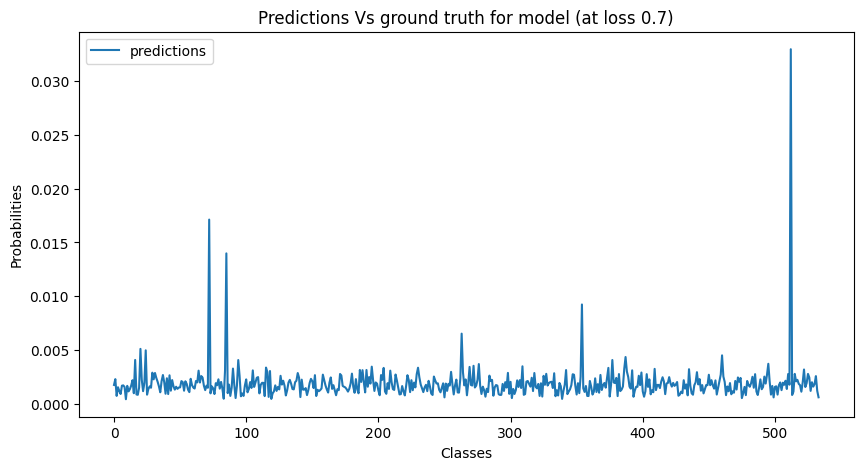

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))


plt.plot(nn.Softmax()(predictions.detach()[0]), label= 'predictions')
# plt.plot(targets[0], label = 'tagets')
plt.legend()
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions Vs ground truth for model (at loss 0.7)')
# plt.savefig('loss_0.7.png', dpi = 300, bbox_inches = 'tight')


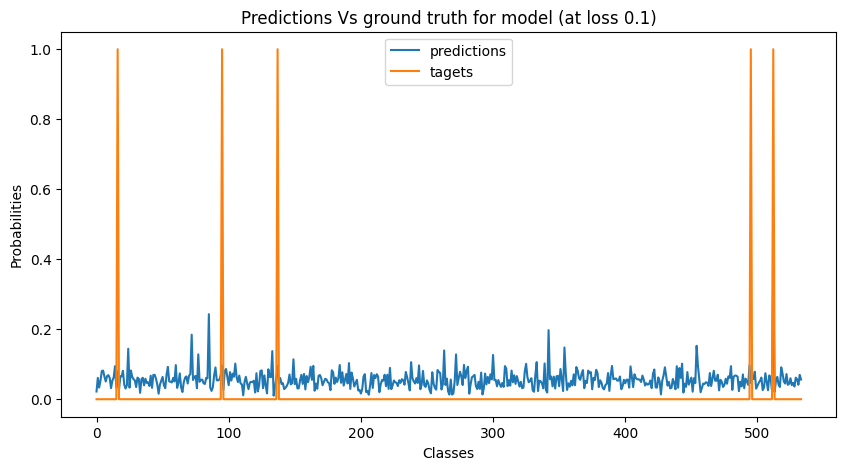

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(predictions.detach()[0], label= 'predictions')
plt.plot(targets[0], label = 'tagets')
plt.legend()
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Predictions Vs ground truth for model (at loss 0.1)')
# plt.savefig('loss_0.1.png', dpi = 300, bbox_inches = 'tight')

In [134]:
m = OACandidateSampler(num_oas)
optimizer = torch.optim.SGD(m.parameters(), lr=0.1)


epochs = 1000
for epoch in range(epochs):
    # images,y = get_batch(10)
    input = np.random.randn(10,49,256)
    input = torch.tensor(input, dtype=torch.float32)
    predictions = m(input)  # Forward pass
    loss =  nn.functional.binary_cross_entropy(predictions, torch.tensor(y, dtype=torch.float32))  # Compute loss
    optimizer.zero_grad()  # Zero gradients
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(images)

Epoch 1/1000, Loss: 0.0019
Epoch 2/1000, Loss: 0.0019
Epoch 3/1000, Loss: 0.0019
Epoch 4/1000, Loss: 0.0019
Epoch 5/1000, Loss: 0.0019
Epoch 6/1000, Loss: 0.0019
Epoch 7/1000, Loss: 0.0019
Epoch 8/1000, Loss: 0.0019
Epoch 9/1000, Loss: 0.0019
Epoch 10/1000, Loss: 0.0019
Epoch 11/1000, Loss: 0.0019
Epoch 12/1000, Loss: 0.0019
Epoch 13/1000, Loss: 0.0019
Epoch 14/1000, Loss: 0.0019
Epoch 15/1000, Loss: 0.0019
Epoch 16/1000, Loss: 0.0019
Epoch 17/1000, Loss: 0.0019
Epoch 18/1000, Loss: 0.0019
Epoch 19/1000, Loss: 0.0019
Epoch 20/1000, Loss: 0.0019
Epoch 21/1000, Loss: 0.0019
Epoch 22/1000, Loss: 0.0019
Epoch 23/1000, Loss: 0.0019
Epoch 24/1000, Loss: 0.0019
Epoch 25/1000, Loss: 0.0019
Epoch 26/1000, Loss: 0.0019
Epoch 27/1000, Loss: 0.0019
Epoch 28/1000, Loss: 0.0019
Epoch 29/1000, Loss: 0.0019
Epoch 30/1000, Loss: 0.0019
Epoch 31/1000, Loss: 0.0019
Epoch 32/1000, Loss: 0.0019
Epoch 33/1000, Loss: 0.0019
Epoch 34/1000, Loss: 0.0019
Epoch 35/1000, Loss: 0.0019
Epoch 36/1000, Loss: 0.0019
E

In [85]:
predictions

tensor([[0.0358, 0.0160, 0.0129,  ..., 0.0075, 0.0421, 0.0460],
        [0.0376, 0.0161, 0.0136,  ..., 0.0076, 0.0412, 0.0452]])

torch.Size([2, 2, 2, 100, 100])


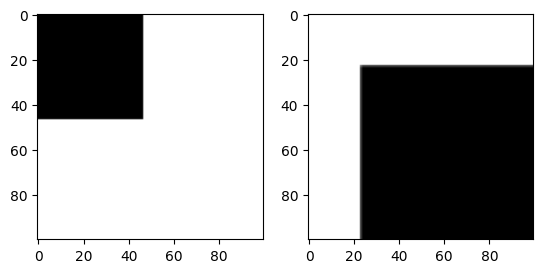

In [17]:
import SpatialFeatureGenerator

reload(SpatialFeatureGenerator)
spatial_feature_generator = SpatialFeatureGenerator.SpatialFeatureGenerator([])

oa_ids = torch.tensor([[1,2], [1,2]], dtype=torch.int32)
maps = spatial_feature_generator.generate_binary_map(oa_ids)
import matplotlib.pyplot as plt
print(maps.shape)
plt.subplot(1,2,1)
plt.imshow(maps[0,0,0], cmap='gray_r')
plt.subplot(1,2,2)

plt.imshow(maps[0,0,1], cmap='gray_r')

In [117]:
import SpatialFeatureGenerator

reload(SpatialFeatureGenerator)
spatial_feature_generator = SpatialFeatureGenerator.SpatialFeatureGenerator([])

oa_ids = torch.tensor([[1,3],[1,3]], dtype=torch.int32)
maps = spatial_feature_generator(oa_ids)
maps.shape

# spatial_feature_generator
# print(maps.shape)
# plt.subplot(1,2,1)
# plt.imshow(maps[0,0,0], cmap='gray_r')
# plt.subplot(1,2,2)

# plt.imshow(maps[0,0,1], cmap='gray_r')
# .shape

torch.Size([2, 2, 256])

In [97]:
from OA_Candidate_Sampler import OACandidateSampler
import torch
# Example usage:
batch_size = 4
input_dim = 256  # Example input feature dimension
hidden_dim = 512
num_oas = len(UniqeOAPairs)  # Example number of object-action pairs
top_k = 5

# Instantiate the model
OASampler = OACandidateSampler(num_oas)


# Forward pass to get top-K OA candidates
indices, confidences = OASampler(encoder_output)

print("Top-K OA Candidates (indices):", indices)
print("Top-K OA Candidates (confidences):", confidences)

torch.Size([2, 256])
Top-K OA Candidates (indices): tensor([0.4742, 0.5498, 0.5315, 0.5022, 0.5301, 0.4953, 0.4106, 0.4795, 0.4520,
        0.5612, 0.5287, 0.5099, 0.4682, 0.4245, 0.5901, 0.4754, 0.4602, 0.5008,
        0.4302, 0.4959, 0.4016, 0.4451, 0.4243, 0.4910, 0.4072, 0.5326, 0.4872,
        0.4433, 0.5147, 0.5421, 0.5327, 0.4535, 0.4833, 0.4594, 0.4803, 0.5472,
        0.5395, 0.5635, 0.4881, 0.5222, 0.5265, 0.4658, 0.4555, 0.4853, 0.4655,
        0.5114, 0.5198, 0.4678, 0.4204, 0.4595, 0.4572, 0.5597, 0.5402, 0.4371,
        0.4521, 0.5194, 0.5351, 0.4870, 0.4916, 0.5290, 0.5572, 0.4910, 0.4574,
        0.4919, 0.5065, 0.5024, 0.5121, 0.5224, 0.5573, 0.5103, 0.4974, 0.5290,
        0.4656, 0.5085, 0.5717, 0.5019, 0.5135, 0.4815, 0.5168, 0.4618, 0.5468,
        0.5558, 0.5448, 0.4093, 0.4160, 0.4656, 0.5004, 0.5013, 0.4835, 0.5173,
        0.5463, 0.4786, 0.4731, 0.4616, 0.5894, 0.5403, 0.5150, 0.5032, 0.4850,
        0.5199, 0.4598, 0.4763, 0.4821, 0.5319, 0.5098, 0.5384, 0.50

In [12]:

oa_pair_templates = [
            ("phone", "talk"), ("book", "read"), ("cup", "drink")  # Extend this list for all OA pairs
        ]
sentences = []
top_k_indices = [[1]]
for batch_indices in top_k_indices:
    batch_sentences = []
    for idx in batch_indices:
        obj, action = oa_pair_templates[idx]
        sentence = f"A person is {action} with a {obj}."
        batch_sentences.append(sentence)
    sentences.extend(batch_sentences)
    
sentences

['A person is read with a book.']